In [1]:
import pandas as pd
import numpy as np

In [2]:
user_df=pd.read_csv('/content/prepared_user_df.csv')
partners_df=pd.read_csv('/content/prepared_partners_df.csv')

In [3]:
del user_df[user_df.columns[0]] #when saving file, a columns unnamed is automatically created at the beginning of the df. Delete it
user_df

,iid,pid,gender,age,imprace,match,dec_u,std_from
0,1,11.0,0,-1.502463,-0.627188,0,1,-1.097690
1,1,12.0,0,-1.502463,-0.627188,0,1,-1.097690
2,1,13.0,0,-1.502463,-0.627188,1,1,-1.097690
3,1,14.0,0,-1.502463,-0.627188,1,1,-1.097690
4,1,15.0,0,-1.502463,-0.627188,1,1,-1.097690
...,...,...,...,...,...,...,...,...
8363,552,526.0,1,-0.380998,-0.978594,0,0,-0.798292
8364,552,527.0,1,-0.380998,-0.978594,0,1,-0.798292
8365,552,528.0,1,-0.380998,-0.978594,0,1,-0.798292
8366,552,529.0,1,-0.380998,-0.978594,0,0,-0.798292


In [4]:
user_df.isnull().sum()

iid         0
pid         0
gender      0
age         0
imprace     0
match       0
dec_u       0
std_from    0
dtype: int64

In [5]:
del partners_df[partners_df.columns[0]]
partners_df

,pid,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha
0,11.0,0.435433,-0.140833,-0.135311,0.372768,-1.148772,-1.071878e+00
1,12.0,1.969294,-1.791148,-2.547788,3.263458,-1.148772,-1.804465e+00
2,13.0,-0.546238,-0.305864,-0.255935,0.083699,-0.053893,-4.625602e-02
3,14.0,0.128661,-1.378569,-0.738430,3.263458,-0.757744,-1.071878e+00
4,15.0,0.128661,-0.965990,-0.135311,-1.072577,-0.366716,1.125883e+00
...,...,...,...,...,...,...,...
8363,526.0,-1.098428,-0.965990,1.070928,0.372768,-0.366716,3.932962e-01
8364,527.0,1.355749,-0.140833,-1.341550,-1.795249,-0.366716,-1.071878e+00
8365,528.0,0.742205,-0.965990,1.070928,-1.072577,-0.366716,-3.290427e-16
8366,529.0,-1.098428,0.271746,0.467809,-1.072577,-0.366716,1.125883e+00


Je prendrai ma variable cible "y" pour l'étape d'entrainement et d'évaluation comme étant la colonne "match". En effet, il s'agit d'un site de rencontres et je pense qu'il est plus important de recommander des matchs potentielles aux utilisateurs que des personnes qu'ils aimeront potentiellement mais qui ne seront pas forcément réciproques.

In [73]:
recommended_partner_df=user_df[['iid']] #dataset to match the results to
recommended_partner_df

,iid
0,1
1,1
2,1
3,1
4,1
...,...
8363,552
8364,552
8365,552
8366,552


In [6]:
y_values=user_df[['match']]
y_values

,match
0,0
1,0
2,1
3,1
4,1
...,...
8363,0
8364,0
8365,0
8366,0


In [7]:
y_values.value_counts()

match
0        6988
1        1380
dtype: int64

In [8]:
del user_df[user_df.columns[5]] #when saving file, a columns unnamed is automatically created at the beginning of the df. Delete it
user_df

,iid,pid,gender,age,imprace,dec_u,std_from
0,1,11.0,0,-1.502463,-0.627188,1,-1.097690
1,1,12.0,0,-1.502463,-0.627188,1,-1.097690
2,1,13.0,0,-1.502463,-0.627188,1,-1.097690
3,1,14.0,0,-1.502463,-0.627188,1,-1.097690
4,1,15.0,0,-1.502463,-0.627188,1,-1.097690
...,...,...,...,...,...,...,...
8363,552,526.0,1,-0.380998,-0.978594,0,-0.798292
8364,552,527.0,1,-0.380998,-0.978594,1,-0.798292
8365,552,528.0,1,-0.380998,-0.978594,1,-0.798292
8366,552,529.0,1,-0.380998,-0.978594,0,-0.798292


## **Contet-based Filtering**

Nos données sont maintenant prêtes à être introduites dans le modèle. J'ai opté pour une approche Deep Learning (d'apprentissage profond). L'idée est de créer 2 réseaux neuronaux convolutionnaires distincts, un pour les utilisateurs et un pour les articles/partenaires. Les réseaux neuronaux vont créer des vecteurs pour chaque utilisateur et partenaire de telle sorte que les 2 vecteurs résultants soient de même dimension (32 unités), Vu et Vp respectivement. De cette façon, quel que soit le nombre de caractéristiques d'entrée de l'utilisateur ou du partenaire, à la fin, ils seront tous deux de la même dimension dans ces vecteurs.

Le produit scalaire des résultats de ces deux réseaux neuronaux constituera notre prédiction, P= Vu * Vp. Un diagramme de l'architecture peut être vu ci-dessous

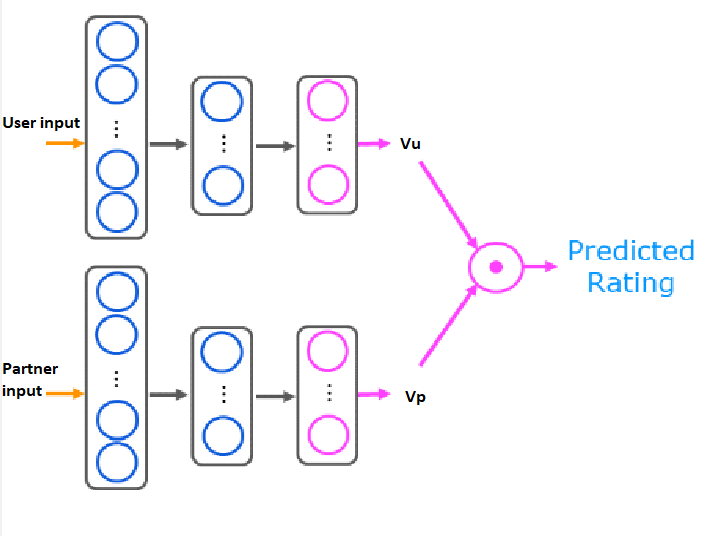

In [9]:
user_df.shape

(8368, 7)

In [10]:
num_user_features = user_df.shape[1] - 2  # remove iid and pid during training
num_partner_features = partners_df.shape[1] - 1  # remove pid at train time
u_s = 2  # start of columns to use in training, user
p_s = 1  # start of columns to use in training, partner
num_user_features

5

**Data splitting into train and test sets**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
user_train, user_test = train_test_split(user_df, train_size=0.80, shuffle=True, random_state=1)
partner_train, partner_test = train_test_split(partners_df, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_values,    train_size=0.80, shuffle=True, random_state=1)
print(f"Forme des données d'entrainement de l'utilisateur: {user_train.shape}")
print(f"Forme des données de test de l'utilisateur: {user_train.shape}")

Forme des données d'entrainement de l'utilisateur: (6694, 7)
Forme des données de test de l'utilisateur: (6694, 7)


In [13]:
y_test.value_counts()

match
0        1382
1         292
dtype: int64

In [14]:
y_train_ = y_train.to_numpy()
y_test_=y_test.to_numpy()

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1, 1))
scaler.fit(y_train_.reshape(-1, 1))
ynorm_train = scaler.transform(y_train_.reshape(-1, 1))
ynorm_test = scaler.transform(y_test_.reshape(-1, 1))
print(ynorm_train.shape, ynorm_test.shape)

(6694, 1) (1674, 1)


- J'ai utilisé un modèle séquentiel Keras
    - La première couche est une couche dense avec 256 unités et une activation relu.
    - La deuxième couche est une couche dense avec 128 unités et une activation relu.
    - La troisième couche est une couche dense avec 32 unités et une activation linéaire ou aucune activation.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# GRADED_CELL
# UNQ_C1

# num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='tanh'),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dense(32)#,activation='sigmoid'), 
])

partner_NN = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='tanh'),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dense(32)#,activation='sigmoid'), 
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1,epsilon=1e-12)
print(vu)

# create the item input and point to the base network
input_partner = tf.keras.layers.Input(shape=(num_partner_features))
vp = partner_NN(input_partner)
vp = tf.linalg.l2_normalize(vp, axis=1,epsilon=1e-12)
print(vp)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vp])
print(output)

# specify the inputs and output of the model
model = keras.Model([input_user, input_partner], output)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.l2_normalize/l2_normalize:0', description="created by layer 'tf.math.l2_normalize'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.l2_normalize_1/l2_normalize:0', description="created by layer 'tf.math.l2_normalize_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dot/Squeeze:0', description="created by layer 'dot'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                  

In [18]:
tf.random.set_seed(1)
partner_NN = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(num_partner_features)),
  tf.keras.layers.Dense(256, activation='tanh'),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dense(32)#,activation='sigmoid'), 
])
# create the item input and point to the base network
# input_partner = tf.keras.layers.Input(shape=(num_partner_features))
# vp = partner_NN(input_partner)
# vp = tf.linalg.l2_normalize(vp, axis=1,epsilon=1e-12)
# vp.predict(partner_df)
p_vecs=partner_NN.predict(partners_df.iloc[:,1:])
p_vecs.shape

(8368, 32)

In [19]:
len(p_vecs)

8368

Je vais utiliser un optimiseur Adam avec un taux d'apprentissage de 0,01, et je vais entraîner le modèle sur 30 époques.J'ai utilisé la fonction de perte binary_crossentropy car il s'agit d'un problème de classification binaire.

In [20]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [21]:
model.compile(
    # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss='binary_crossentropy', #tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.05),#keras.optimizers.RMSprop(learning_rate=3e-4),#SGD(learning_rate=0,momentum=0.9,nesterov=False, name="SDG"),
    metrics=["accuracy"],
)

In [22]:
tf.random.set_seed(1)
model.fit([user_train.iloc[:, u_s:], partner_train.iloc[:, p_s:]], y_train, epochs=100)

Epoch 1/100
210/210 [==============================] - 2s 3ms/step - loss: 1.6764 - accuracy: 0.8106
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 2.4611 - accuracy: 0.8218
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 2.2991 - accuracy: 0.8297
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.7386 - accuracy: 0.7556
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4913 - accuracy: 0.8375
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4720 - accuracy: 0.8375
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4449 - accuracy: 0.8375
Epoch 8/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4289 - accuracy: 0.8375
Epoch 9/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.8373
Epoch 10/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4664 - accura

In [23]:
model.evaluate([user_test.iloc[:, u_s:], partner_test.iloc[:, p_s:]], y_test)

53/53 [==============================] - 1s 4ms/step - loss: 0.4203 - accuracy: 0.8256


[0.42029324173927307, 0.8255674839019775]

In [24]:
model.predict([user_test.iloc[:, u_s:], partner_test.iloc[:, p_s:]])

array([[-0.02382717],
       [-0.0589887 ],
       [ 0.17698671],
       ...,
       [ 0.17264883],
       [-0.06238994],
       [ 0.25192684]], dtype=float32)

In [25]:
def result(pred):
  m= pred.shape[0]
  Y_pred=np.zeros((m,1))

  for i in range(pred.shape[0]):
    # print(pred[i][0])
    Y_pred[i][0]= 1 if pred[i][0]>0 else 0

  return Y_pred

In [26]:
o=model.predict([user_test.iloc[:, u_s:], partner_test.iloc[:, p_s:]])
result(o)

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]])

**Recommandations de personnes non 
rencontrées**

Tout d'abord, je vais créer un nouvel utilisateur et faire en sorte que le modèle suggère des partenaires pour cet utilisateur. 

Générer et répliquer le nouveau vecteur utilisateur pour correspondre au nombre de dans l'ensemble de données.

In [28]:
iid = 553
pid = 1
dec_u=1
gender = 0
age = 23
imprace = 2
std_from = 1

user_vec = np.array([[iid, pid, dec_u, gender,age, imprace, std_from]])

In [29]:
user_vec.shape

(1, 7)

Remodeler l'entrée de l'utilisateur pour qu'elle ait la même forme que celle des partenaires, afin que la sortie du modèle ait la même forme, ce qui permettra d'effectuer le produit scalaire.Je génère également le meme nombre de lignes pour les utilisateurs, afin qu'elles soient égales à celui des partenaires pour être en mesure de prédire la correspondance entre l'utilisateur et chaque partenaire individuel.

In [30]:
user_vecs=np.array([user_vec.T,]*len(partners_df))
user_vecs=user_vecs.squeeze()

In [31]:
user_vecs.shape

(8368, 7)

In [32]:
partners_df.shape

(8368, 7)

Je standardise les entrés de l'utilisateur

In [33]:
user = (user_vecs - user_vecs.mean())/(user_vecs.std())
user

array([[ 2.44756575, -0.42702211, -0.42702211, ..., -0.3124552 ,
        -0.42181452, -0.42702211],
       [ 2.44756575, -0.42702211, -0.42702211, ..., -0.3124552 ,
        -0.42181452, -0.42702211],
       [ 2.44756575, -0.42702211, -0.42702211, ..., -0.3124552 ,
        -0.42181452, -0.42702211],
       ...,
       [ 2.44756575, -0.42702211, -0.42702211, ..., -0.3124552 ,
        -0.42181452, -0.42702211],
       [ 2.44756575, -0.42702211, -0.42702211, ..., -0.3124552 ,
        -0.42181452, -0.42702211],
       [ 2.44756575, -0.42702211, -0.42702211, ..., -0.3124552 ,
        -0.42181452, -0.42702211]])

In [34]:
#Prediction
user_pred=model.predict([user[:,2:], partners_df.iloc[:, p_s:]])


In [66]:
predictions=result(user_pred)

Je récupère les indexes des matchs potentiels , qui sont donc ceux que nous recommenderons a l'utilisateur 

In [55]:
matches_ind=(np.where(predictions==1)[0]).tolist()
matches_ind

[2606,
 2626,
 2646,
 2666,
 2686,
 2706,
 2726,
 2746,
 2766,
 2786,
 2806,
 2826,
 2846,
 2866,
 2886,
 2906,
 2926,
 2946,
 2966,
 2986]

Ensuite, j'extrais les identifiants utilisateurs correspondant à ces indices

In [75]:
def matches(pred):
  matches_ind=(np.where(pred==1)[0]).tolist() #get the matches indeces
  matches=[]
  for i in matches_ind:
    matches.append(recommended_partner_df._get_value(i,'iid')) #get the corresponding partner's
  print('Les identifiants des utilisateurs qui pourraient être des correspondances potentielles sont les suivants')
  return set(matches)


In [76]:
matches(predictions)

Les identifiants des utilisateurs qui pourraient être des correspondances potentielles sont les suivants


{194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213}

In [49]:
np.unique(result(user_pred), return_counts=True)

(array([0., 1.]), array([8348,   20]))

In [38]:
model.save("rec_system")
print("Modèle sauvegardé")

INFO:tensorflow:Assets written to: rec_system/assets
Modèle sauvegardé
